In [8]:
import pandas as pd
from sqlalchemy import text
from google.cloud import bigquery

import matplotlib.pyplot as plt

# Uses Application Default Credentials (run `gcloud auth application-default login` first)
bq_client = bigquery.Client(project="prizepicksanalytics")


In [9]:
tennis_stat_type_query = """
select distinct stat_type_name, stat_type_id from `prizepicksanalytics.pick_level.pick_level` where league_name = 'TENNIS'"""
df = bq_client.query(tennis_stat_type_query).to_dataframe()
df


,stat_type_name,stat_type_id
0,Break Points Won,103
1,Fantasy Score,14
2,Total Sets,64
3,Total Tie Breaks,1012
4,Total Games Lost,845
5,Total Games Won,63
6,Total Games,62
7,Aces,61
8,Double Faults,864
9,Matches Won,84


In [10]:
tennis_games_won = """
   WITH RankedPicks AS (
    SELECT
      *,
      ROW_NUMBER() OVER(
        PARTITION BY 
          overall_league, 
          description, 
          stat_type_id, 
          league_name, 
          player_name, 
          CAST(pred_line_score AS STRING), 
          stat_type_name, 
          outcome_was_over, 
          outcome_was_under, 
          CAST(score AS STRING)
        ORDER BY 
          created_at_est DESC
      ) as rn
    FROM
      `prizepicksanalytics.pick_level.pick_level`
    WHERE
      overall_league IN ('TENNIS')
      AND league_name IN ('TENNIS')
      AND stat_type_id IN (63)
      AND NOT demon_pick 
      AND NOT goblin_pick
      AND NOT is_off_the_board
      AND was_refunded_cancelled = 0
  )
  SELECT
      overall_league,
      created_at_est,
      description,
      stat_type_id,
      league_name,
      player_name,
      pred_line_score,
      stat_type_name,
      outcome_was_over,
      outcome_was_under,
      score
  FROM
      RankedPicks
  WHERE
      rn = 1
      """

In [16]:
# Fetch fantasy score actuals from BigQuery
df = bq_client.query(tennis_games_won).to_dataframe()

# Drop any super old picks
df = df[df.created_at_est > "2020-01-01"]
df.head()

,overall_league,created_at_est,description,stat_type_id,league_name,player_name,pred_line_score,stat_type_name,outcome_was_over,outcome_was_under,score
0,TENNIS,2025-08-27 11:00:00.845812+00:00,Jerome Kym,63,TENNIS,Brandon Nakashima,20.5,Total Games Won,1,0,29.0
1,TENNIS,2026-01-31 16:15:03.020005+00:00,Sonay Kartal,63,TENNIS,Aliaksandra Sasnovich,11.5,Total Games Won,0,0,0.0
2,TENNIS,2025-07-02 13:25:02.972262+00:00,Cristian Garin,63,TENNIS,Arthur Rinderknech,20.5,Total Games Won,1,0,26.0
3,TENNIS,2025-08-27 17:11:28.907353+00:00,Holger Rune,63,TENNIS,Jan-Lennard Struff,17.5,Total Games Won,1,0,26.0
4,TENNIS,2025-02-08 09:59:49.332285+00:00,Lucia Bronzetti,63,TENNIS,Katerina Siniakova,12.5,Total Games Won,0,1,0.0


In [17]:
def assign_segment(line):
    if line < 13.5:
        return "BO3_likely"
    elif line <= 19.5:
        return "Ambiguous"
    else:
        return "BO5_likely"

df["segment"] = df["pred_line_score"].apply(assign_segment)

In [20]:
# Calculate statistics for each segment
segment_stats = df.groupby("segment").agg(
    count=("score", "count"),
    mean_line=("pred_line_score", "mean"),
    mean_actual=("score", "mean"),
    std_actual=("score", "std"),
    min_line=("pred_line_score", "min"),
    max_line=("pred_line_score", "max"),
    min_actual=("score", "min"),
    max_actual=("score", "max"),
).round(2)

print("Segment Statistics:")
print(segment_stats.to_string())

# Distribution of segments
print(f"\nSegment Distribution:")
print(df["segment"].value_counts())

Segment Statistics:
            count  mean_line  mean_actual  std_actual  min_line  max_line  min_actual  max_actual
segment                                                                                          
Ambiguous     681      17.48        17.14        6.25      13.5      19.5         0.0        33.0
BO3_likely   6488      11.44        11.15        4.72       0.5      13.0         0.0       130.0
BO5_likely    536      20.93        20.41        5.38      20.0      31.5         0.0        32.0

Segment Distribution:
segment
BO3_likely    6488
Ambiguous      681
BO5_likely     536
Name: count, dtype: int64


In [22]:
import numpy as np
from scipy import stats
def compute_calibration(df_segment, segment_name, std_override=None):
    """
    Compute calibration metrics for a segment.
    For each pick, we create a normal distribution centered at pred_line_score 
    with the segment's std, then check what percentile the actual score falls at.
    """
    if len(df_segment) < 10:
        return None
    
    # Use segment's empirical std or override
    segment_std = std_override if std_override else df_segment["score"].std()
    
    percentiles = []
    for _, row in df_segment.iterrows():
        # Create normal distribution centered at the predicted line
        dist = stats.norm(loc=row["pred_line_score"], scale=segment_std)
        # Find what percentile the actual score falls at
        percentile = dist.cdf(row["score"])
        percentiles.append(percentile)
    
    return np.array(percentiles)

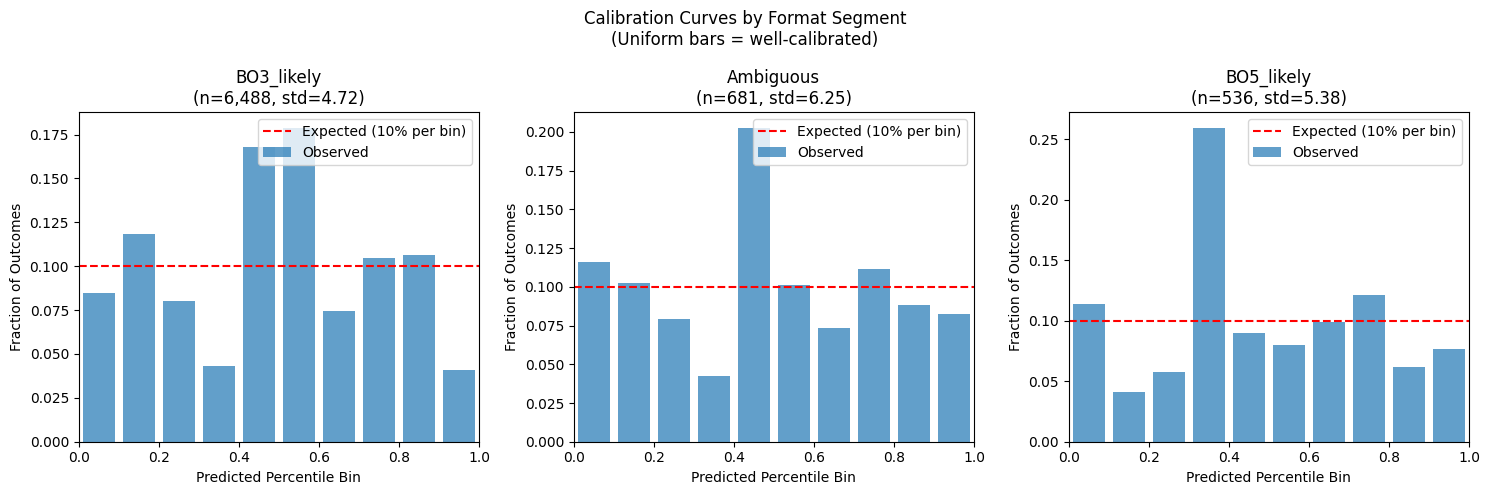

In [24]:
def plot_calibration_curve(percentiles, segment_name, ax):
    """
    Plot calibration curve: expected percentiles vs observed frequency.
    A well-calibrated model has points along the diagonal.
    """
    # Define bins for percentiles
    bins = np.linspace(0, 1, 11)  # 0, 0.1, 0.2, ..., 1.0
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate observed frequency for each bin
    observed_freq = []
    for i in range(len(bins) - 1):
        in_bin = (percentiles >= bins[i]) & (percentiles < bins[i+1])
        observed_freq.append(in_bin.mean())
    
    # Plot
    ax.bar(bin_centers, observed_freq, width=0.08, alpha=0.7, label="Observed")
    ax.plot([0, 1], [0.1, 0.1], 'r--', label="Expected (10% per bin)")
    ax.set_xlabel("Predicted Percentile Bin")
    ax.set_ylabel("Fraction of Outcomes")
    ax.set_title(f"{segment_name}\n(n={len(percentiles):,}, std={df[df['segment']==segment_name]['score'].std():.2f})")
    ax.set_xlim(0, 1)
    ax.legend()
    
    return observed_freq


# Plot calibration curves for each segment
segments = ["BO3_likely", "Ambiguous", "BO5_likely"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

calibration_results = {}
for ax, segment in zip(axes, segments):
    df_seg = df[df["segment"] == segment]
    if len(df_seg) >= 10:
        percentiles = compute_calibration(df_seg, segment)
        calibration_results[segment] = percentiles
        plot_calibration_curve(percentiles, segment, ax)
    else:
        ax.set_title(f"{segment}\n(insufficient data)")

fig.suptitle("Calibration Curves by Format Segment\n(Uniform bars = well-calibrated)", fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
# Quantitative Calibration Metrics
# Key metrics:
# 1. Coverage: What % of actuals fall within predicted 80% interval (10th-90th percentile)?
# 2. Calibration Error: How far off are the observed percentile frequencies from expected?

def compute_calibration_metrics(percentiles, segment_name):
    """Compute quantitative calibration metrics."""
    
    # Coverage metrics
    coverage_50 = ((percentiles >= 0.25) & (percentiles <= 0.75)).mean()  # 50% interval
    coverage_80 = ((percentiles >= 0.10) & (percentiles <= 0.90)).mean()  # 80% interval
    coverage_95 = ((percentiles >= 0.025) & (percentiles <= 0.975)).mean()  # 95% interval
    
    # Mean Absolute Calibration Error (MACE)
    # For a well-calibrated model, percentiles should be uniform [0,1]
    # Check if each decile has ~10% of outcomes
    bins = np.linspace(0, 1, 11)
    observed_freq = []
    for i in range(len(bins) - 1):
        in_bin = (percentiles >= bins[i]) & (percentiles < bins[i+1])
        observed_freq.append(in_bin.mean())
    
    expected_freq = 0.1  # Each bin should have 10%
    mace = np.mean(np.abs(np.array(observed_freq) - expected_freq))
    
    # Check for systematic bias (are we over/under predicting?)
    median_percentile = np.median(percentiles)  # Should be ~0.5 if well-calibrated
    
    return {
        "segment": segment_name,
        "n": len(percentiles),
        "coverage_50": f"{coverage_50:.1%}",
        "coverage_80": f"{coverage_80:.1%}",
        "coverage_95": f"{coverage_95:.1%}",
        "mace": f"{mace:.3f}",
        "median_percentile": f"{median_percentile:.2f}",
        "interpretation": "over-predicting" if median_percentile > 0.55 else "under-predicting" if median_percentile < 0.45 else "balanced"
    }

# Compute metrics for each segment
print("Calibration Metrics by Segment:")
print("=" * 80)
print(f"{'Segment':<15} {'N':>8} {'Cov50%':>10} {'Cov80%':>10} {'Cov95%':>10} {'MACE':>8} {'Med%ile':>10} {'Bias':>15}")
print("-" * 80)

for segment in segments:
    if segment in calibration_results:
        metrics = compute_calibration_metrics(calibration_results[segment], segment)
        print(f"{metrics['segment']:<15} {metrics['n']:>8} {metrics['coverage_50']:>10} {metrics['coverage_80']:>10} {metrics['coverage_95']:>10} {metrics['mace']:>8} {metrics['median_percentile']:>10} {metrics['interpretation']:>15}")

print("-" * 80)
print("""
Interpretation Guide:
- Coverage 50%: Should be ~50% (% of actuals in 25th-75th percentile)
- Coverage 80%: Should be ~80% (% of actuals in 10th-90th percentile)  
- Coverage 95%: Should be ~95% (% of actuals in 2.5th-97.5th percentile)
- MACE: Lower is better (0 = perfect calibration)
- Median Percentile: Should be ~0.50 (0.50 = no bias, >0.5 = over-predicting, <0.5 = under-predicting)
""")

Calibration Metrics by Segment:
Segment                N     Cov50%     Cov80%     Cov95%     MACE    Med%ile            Bias
--------------------------------------------------------------------------------
BO3_likely          6488      57.7%      87.4%      97.9%    0.035       0.50        balanced
Ambiguous            681      50.4%      80.2%      95.9%    0.027       0.47        balanced
BO5_likely           536      62.7%      81.0%      95.1%    0.039       0.43 under-predicting
--------------------------------------------------------------------------------

Interpretation Guide:
- Coverage 50%: Should be ~50% (% of actuals in 25th-75th percentile)
- Coverage 80%: Should be ~80% (% of actuals in 10th-90th percentile)  
- Coverage 95%: Should be ~95% (% of actuals in 2.5th-97.5th percentile)
- MACE: Lower is better (0 = perfect calibration)
- Median Percentile: Should be ~0.50 (0.50 = no bias, >0.5 = over-predicting, <0.5 = under-predicting)



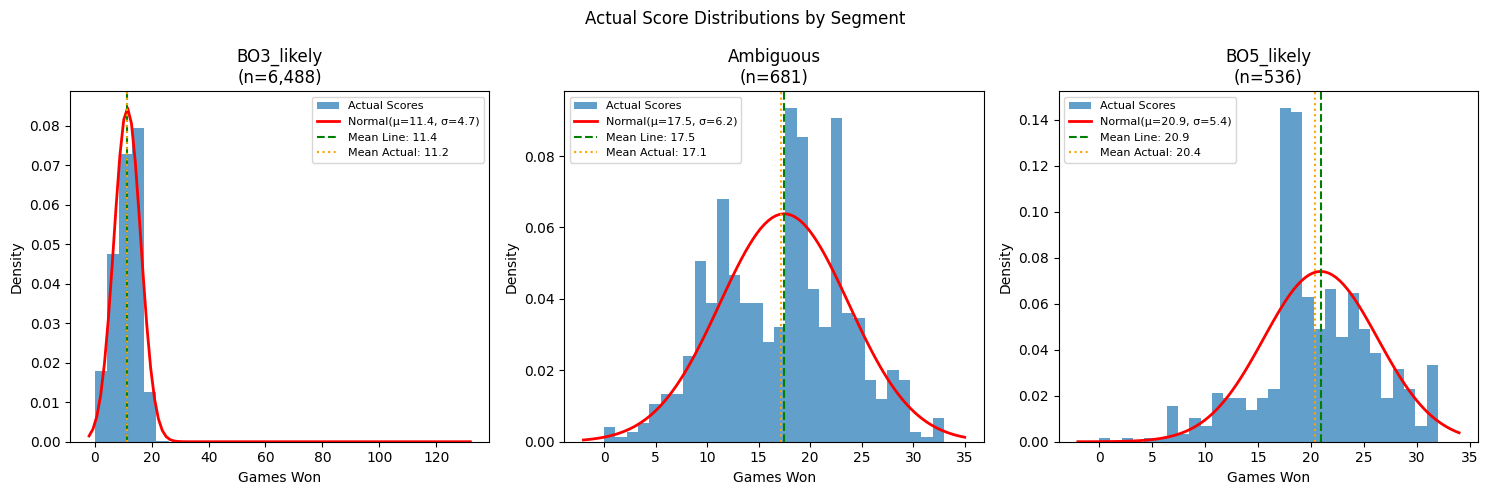

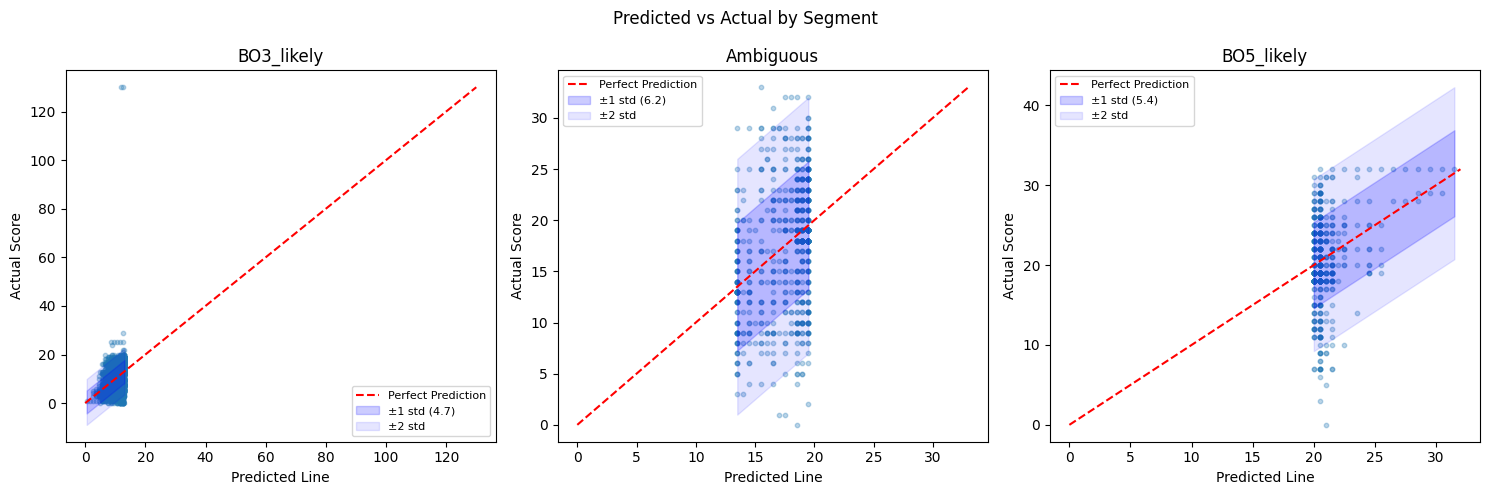

In [27]:
# Visualize actual score distributions by segment
# This helps verify if the segments have meaningfully different characteristics

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, segment in zip(axes, segments):
    df_seg = df[df["segment"] == segment]
    if len(df_seg) >= 10:
        # Plot actual scores
        ax.hist(df_seg["score"], bins=30, density=True, alpha=0.7, label="Actual Scores")
        
        # Overlay the fitted normal distribution
        segment_mean = df_seg["pred_line_score"].mean()
        segment_std = df_seg["score"].std()
        x = np.linspace(df_seg["score"].min() - 2, df_seg["score"].max() + 2, 100)
        ax.plot(x, stats.norm.pdf(x, segment_mean, segment_std), 'r-', lw=2, 
                label=f"Normal(μ={segment_mean:.1f}, σ={segment_std:.1f})")
        
        ax.axvline(segment_mean, color='green', linestyle='--', label=f"Mean Line: {segment_mean:.1f}")
        ax.axvline(df_seg["score"].mean(), color='orange', linestyle=':', label=f"Mean Actual: {df_seg['score'].mean():.1f}")
        
        ax.set_xlabel("Games Won")
        ax.set_ylabel("Density")
        ax.set_title(f"{segment}\n(n={len(df_seg):,})")
        ax.legend(fontsize=8)

fig.suptitle("Actual Score Distributions by Segment", fontsize=12)
plt.tight_layout()
plt.show()

# Also show the relationship between predicted line and actual score
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, segment in zip(axes, segments):
    df_seg = df[df["segment"] == segment]
    if len(df_seg) >= 10:
        ax.scatter(df_seg["pred_line_score"], df_seg["score"], alpha=0.3, s=10)
        
        # Perfect prediction line
        min_val = min(df_seg["pred_line_score"].min(), df_seg["score"].min())
        max_val = max(df_seg["pred_line_score"].max(), df_seg["score"].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
        
        # Add std bands
        segment_std = df_seg["score"].std()
        x_line = np.linspace(df_seg["pred_line_score"].min(), df_seg["pred_line_score"].max(), 100)
        ax.fill_between(x_line, x_line - segment_std, x_line + segment_std, alpha=0.2, color='blue', label=f"±1 std ({segment_std:.1f})")
        ax.fill_between(x_line, x_line - 2*segment_std, x_line + 2*segment_std, alpha=0.1, color='blue', label=f"±2 std")
        
        ax.set_xlabel("Predicted Line")
        ax.set_ylabel("Actual Score")
        ax.set_title(f"{segment}")
        ax.legend(fontsize=8)

fig.suptitle("Predicted vs Actual by Segment", fontsize=12)
plt.tight_layout()
plt.show()

In [30]:
# Experiment with different segmentation strategies
# Compare: 3 segments vs quartiles vs deciles

def evaluate_segmentation(df, segment_col, segment_order=None):
    """Evaluate a segmentation strategy using average MACE across segments."""
    segments = segment_order if segment_order else df[segment_col].unique()
    total_mace = 0
    total_n = 0
    
    results = []
    for segment in segments:
        df_seg = df[df[segment_col] == segment]
        if len(df_seg) >= 10:
            percentiles = compute_calibration(df_seg, segment)
            
            # MACE calculation
            bins = np.linspace(0, 1, 11)
            observed_freq = []
            for i in range(len(bins) - 1):
                in_bin = (percentiles >= bins[i]) & (percentiles < bins[i+1])
                observed_freq.append(in_bin.mean())
            mace = np.mean(np.abs(np.array(observed_freq) - 0.1))
            
            results.append({
                "segment": segment,
                "n": len(df_seg),
                "std": df_seg["score"].std(),
                "mace": mace
            })
            total_mace += mace * len(df_seg)
            total_n += len(df_seg)
    
    weighted_mace = total_mace / total_n if total_n > 0 else float('inf')
    return results, weighted_mace

# Strategy 1: Current 3-segment approach
print("=" * 60)
print("Strategy 1: 3 Format Segments (BO3_likely, Ambiguous, BO5_likely)")
results_3seg, mace_3seg = evaluate_segmentation(df, "segment", ["BO3_likely", "Ambiguous", "BO5_likely"])
for r in results_3seg:
    print(f"  {r['segment']:<15}: n={r['n']:>6}, std={r['std']:.2f}, MACE={r['mace']:.4f}")
print(f"  Weighted MACE: {mace_3seg:.4f}")

# Strategy 2: Quartiles by line
df["line_quartile"] = pd.qcut(df["pred_line_score"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
print("\n" + "=" * 60)
print("Strategy 2: Quartiles by Predicted Line")
results_quartile, mace_quartile = evaluate_segmentation(df, "line_quartile", ["Q1", "Q2", "Q3", "Q4"])
for r in results_quartile:
    print(f"  {r['segment']:<15}: n={r['n']:>6}, std={r['std']:.2f}, MACE={r['mace']:.4f}")
print(f"  Weighted MACE: {mace_quartile:.4f}")

# Strategy 3: Deciles by line
try:
    df["line_decile"] = pd.qcut(df["pred_line_score"], q=10, duplicates='drop')
    # Rename the interval labels to D1, D2, etc.
    decile_labels = {cat: f"D{i+1}" for i, cat in enumerate(sorted(df["line_decile"].dropna().unique()))}
    df["line_decile"] = df["line_decile"].map(decile_labels)
    
    print("\n" + "=" * 60)
    print(f"Strategy 3: Deciles by Predicted Line ({len(decile_labels)} bins after deduplication)")
    results_decile, mace_decile = evaluate_segmentation(df, "line_decile")
    for r in sorted(results_decile, key=lambda x: x['segment']):
        print(f"  {r['segment']:<15}: n={r['n']:>6}, std={r['std']:.2f}, MACE={r['mace']:.4f}")
    print(f"  Weighted MACE: {mace_decile:.4f}")
except Exception as e:
    print(f"\n  Deciles failed: {e}")
    mace_decile = float('inf')

# Summary
print("\n" + "=" * 60)
print("SUMMARY - Lower MACE = Better Calibration")
print(f"  3-Segment:  {mace_3seg:.4f}")
print(f"  Quartiles:  {mace_quartile:.4f}")
print(f"  Deciles:    {mace_decile:.4f}")
best = min([("3-Segment", mace_3seg), ("Quartiles", mace_quartile), ("Deciles", mace_decile)], key=lambda x: x[1])
print(f"\n  Best strategy: {best[0]}")

Strategy 1: 3 Format Segments (BO3_likely, Ambiguous, BO5_likely)
  BO3_likely     : n=  6488, std=4.72, MACE=0.0352
  Ambiguous      : n=   681, std=6.25, MACE=0.0269
  BO5_likely     : n=   536, std=5.38, MACE=0.0389
  Weighted MACE: 0.0347

Strategy 2: Quartiles by Predicted Line
  Q1             : n=  2304, std=4.46, MACE=0.0195
  Q2             : n=  3368, std=4.78, MACE=0.0461
  Q3             : n=   816, std=3.43, MACE=0.0569
  Q4             : n=  1217, std=6.10, MACE=0.0254
  Weighted MACE: 0.0360

Strategy 3: Deciles by Predicted Line (7 bins after deduplication)
  D1             : n=   876, std=4.43, MACE=0.0219
  D2             : n=   710, std=4.35, MACE=0.0315
  D3             : n=  1462, std=5.23, MACE=0.0422
  D4             : n=  2624, std=4.36, MACE=0.0496
  D5             : n=   816, std=3.43, MACE=0.0569
  D6             : n=   495, std=6.37, MACE=0.0224
  D7             : n=   722, std=5.41, MACE=0.0386
  Weighted MACE: 0.0414

SUMMARY - Lower MACE = Better Calibrat

________

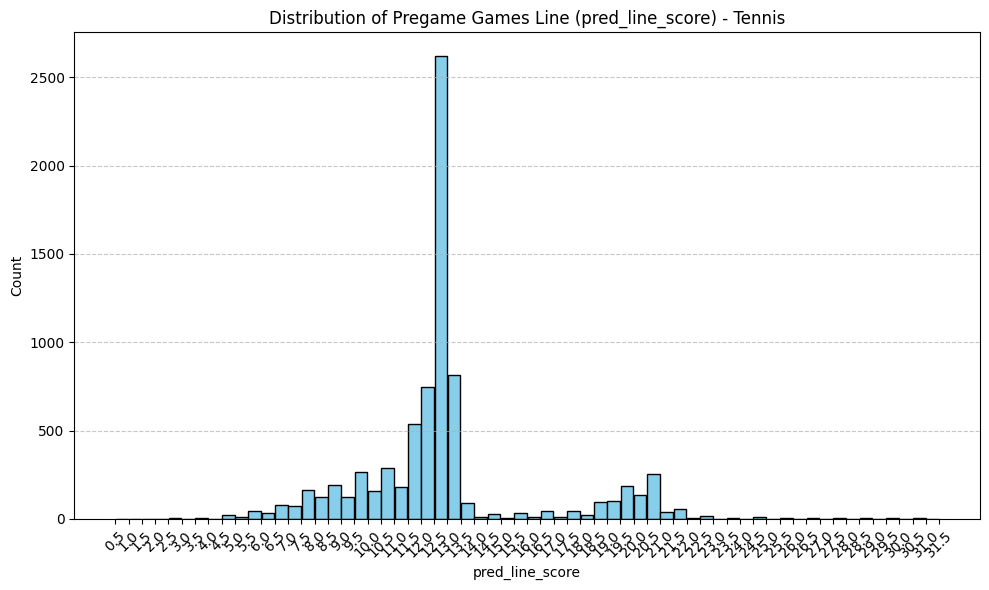

In [12]:
# plot distribution of pred_line_score at every half point from smallest value to largest value in dataset
import numpy as np
import matplotlib.pyplot as plt

# Calculate the range of pred_line_score from the data
min_pred = df["pred_line_score"].min()
max_pred = df["pred_line_score"].max()

# Prepare the bins: every 0.5 increment starting from the lowest half-step below min_pred
bins = np.arange(np.floor(min_pred * 2) / 2, np.ceil(max_pred * 2) / 2 + 0.5, 0.5)

plt.figure(figsize=(10,6))
plt.hist(df["pred_line_score"], bins=bins, rwidth=0.95, color="skyblue", edgecolor="black")
plt.title("Distribution of Pregame Games Line (pred_line_score) - Tennis")
plt.xlabel("pred_line_score")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()






In [13]:
# put each value into a quartile (qcut = quantile-based, equal count per bin)
df["quartile"] = pd.qcut(df["pred_line_score"], q=4)
df.head()



,overall_league,created_at_est,description,stat_type_id,league_name,player_name,pred_line_score,stat_type_name,outcome_was_over,outcome_was_under,score,quartile
0,TENNIS,2025-08-27 11:00:00.845812+00:00,Jerome Kym,63,TENNIS,Brandon Nakashima,20.5,Total Games Won,1,0,29.0,"(13.0, 31.5]"
1,TENNIS,2026-01-31 16:15:03.020005+00:00,Sonay Kartal,63,TENNIS,Aliaksandra Sasnovich,11.5,Total Games Won,0,0,0.0,"(0.499, 11.5]"
2,TENNIS,2025-07-02 13:25:02.972262+00:00,Cristian Garin,63,TENNIS,Arthur Rinderknech,20.5,Total Games Won,1,0,26.0,"(13.0, 31.5]"
3,TENNIS,2025-08-27 17:11:28.907353+00:00,Holger Rune,63,TENNIS,Jan-Lennard Struff,17.5,Total Games Won,1,0,26.0,"(13.0, 31.5]"
4,TENNIS,2025-02-08 09:59:49.332285+00:00,Lucia Bronzetti,63,TENNIS,Katerina Siniakova,12.5,Total Games Won,0,1,0.0,"(11.5, 12.5]"


In [ ]:

two_set_match = df[df["pred_line_score"] <= 14]

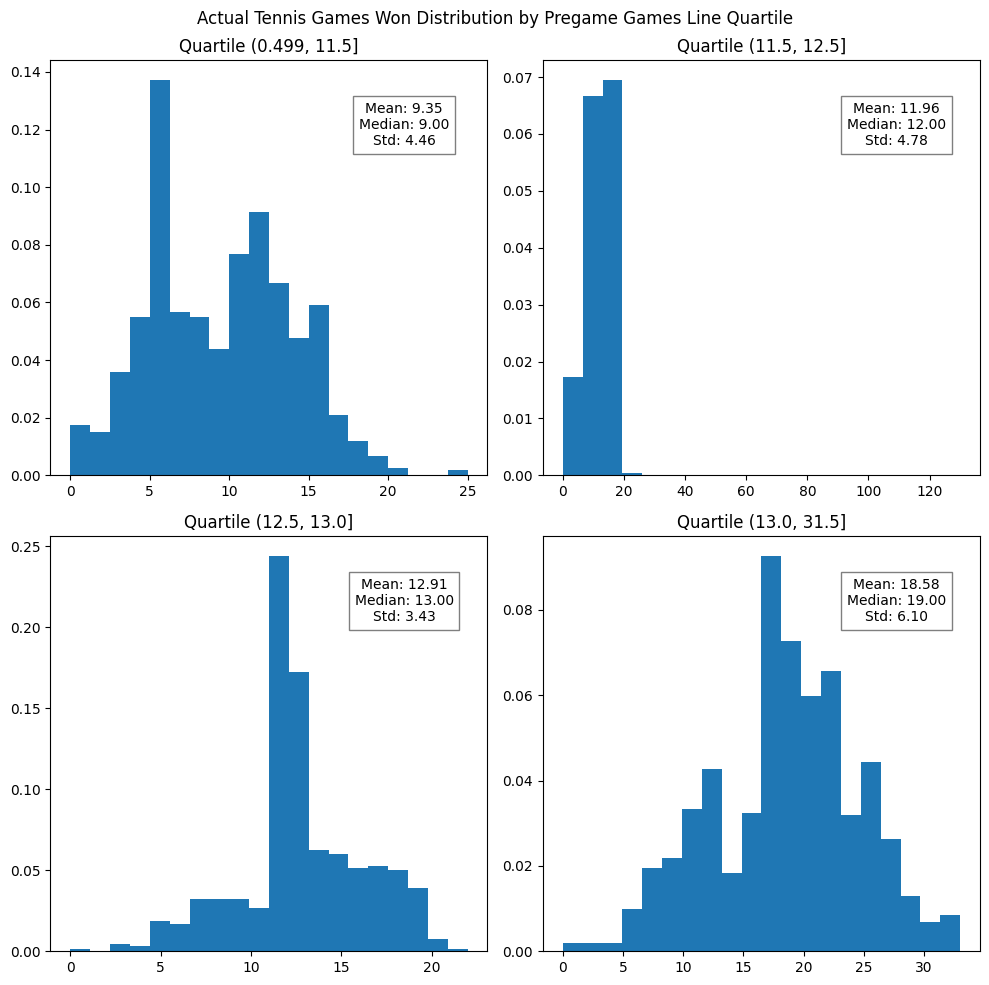

In [15]:
# plot a histogram of the actual values split by quartile
# split into subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # convert 2D array to 1D for easy indexing
for i, quartile in enumerate(df.quartile.unique().sort_values()):
    data = df[df.quartile == quartile]["score"]
    axes[i].hist(data, bins=20, density=True)
    axes[i].set_title(f"Quartile {quartile}")
    # calculate the mean, median, and standard deviation of the data
    # and put in text box
    max_density = axes[i].get_ylim()[1]
    max_value = axes[i].get_xlim()[1]
    axes[i].text(max_value * 0.8, max_density * 0.9, f"Mean: {data.mean():.2f}\nMedian: {data.median():.2f}\nStd: {data.std():.2f}",
                 ha="center", va="top",
                 bbox=dict(facecolor="white", alpha=0.5))

fig.suptitle("Actual Tennis Games Won Distribution by Pregame Games Line Quartile")
plt.tight_layout()
plt.show()


In [25]:
# Calculate the std of the actuals within each quartile, and then print list needed
# for the std map [(upper_lim, std), (upper_lim, std), ...]
quartile_stds = []
for quartile in df.quartile.unique().sort_values():
    data = df[df.quartile == quartile]["score"]
    quartile_stds.append((quartile.right, data.std().round(1)))

#print without np.float64
print([(float(upper_lim), float(std)) for upper_lim, std in quartile_stds])


[(24.5, 9.6), (27.6, 9.8), (31.5, 10.2), (52.5, 11.3)]
